In [1]:
from IPython.display import Image

### Q1. (15pts) 

（Solve by hand)

Given the following learned Bayesian network structure explaining the relationships

between variables in container shipping data:

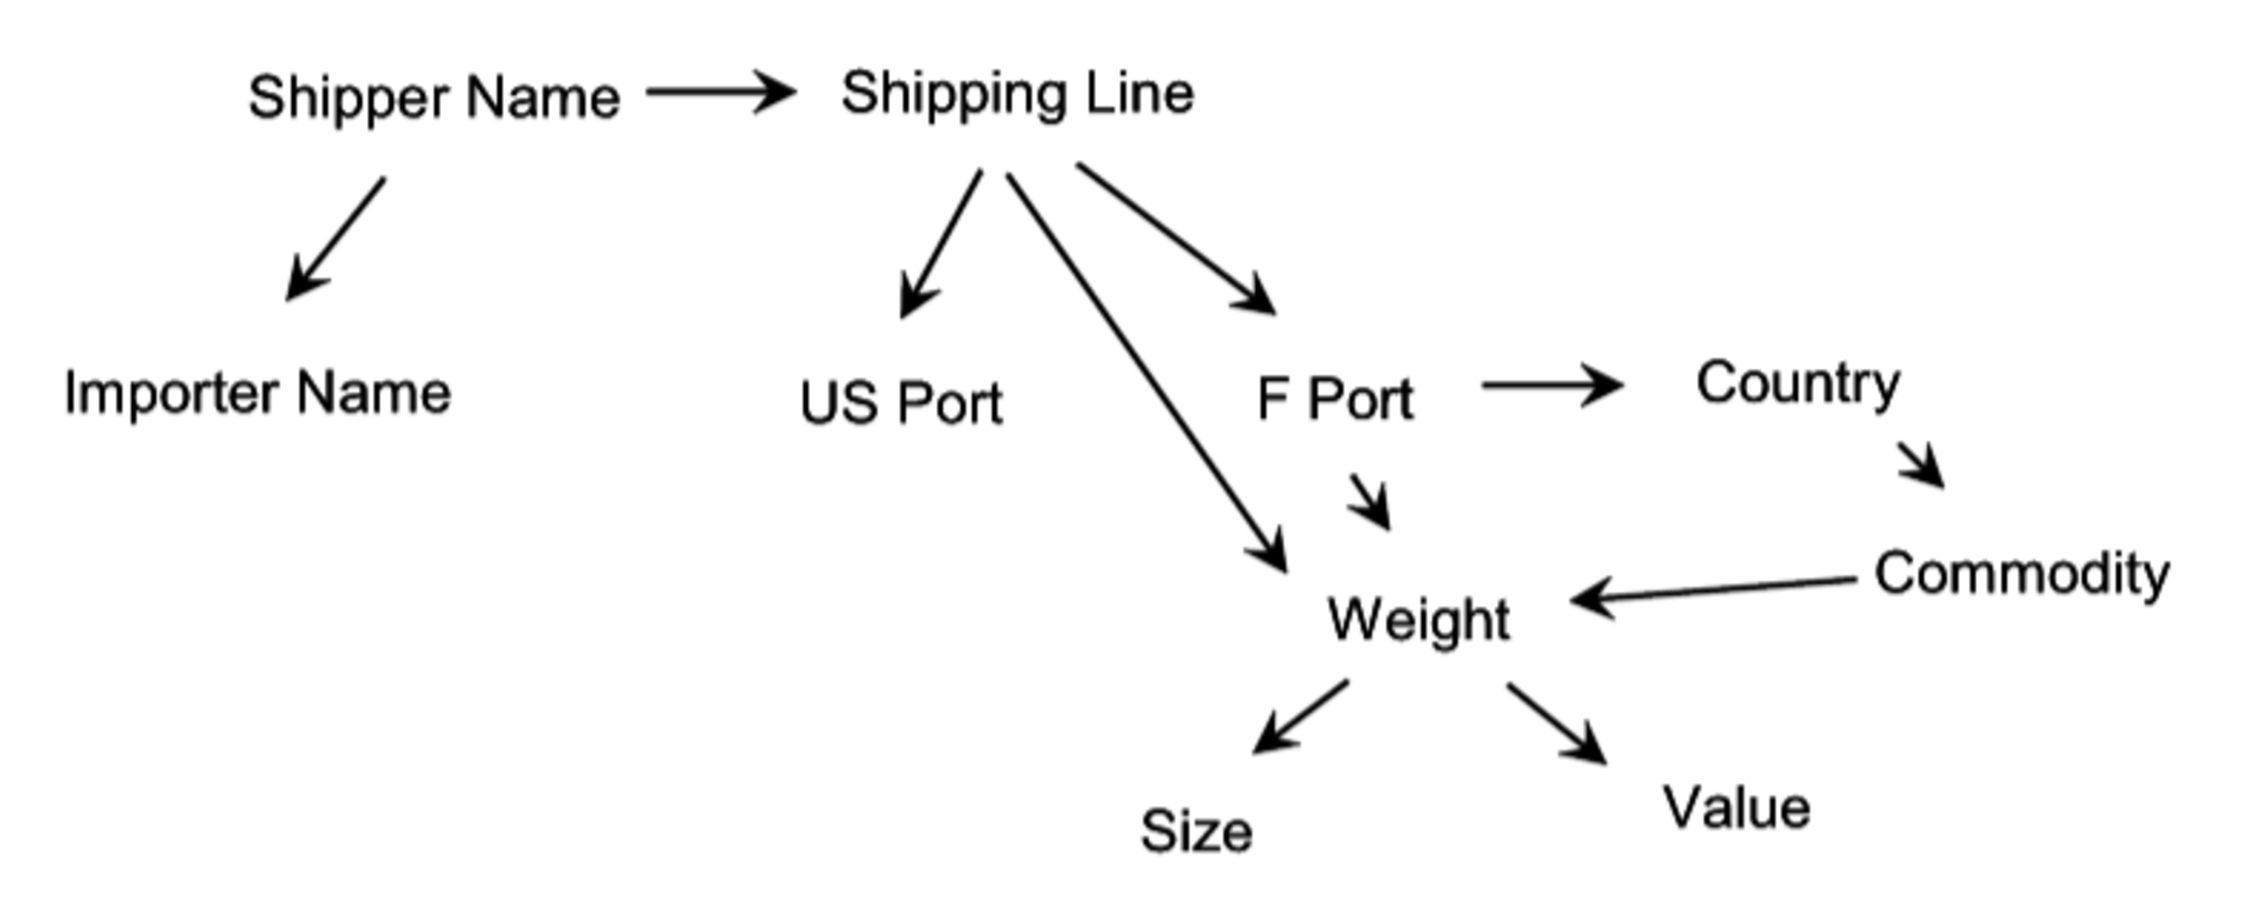

In [2]:
Image('Q1.png')

1) Which of the following conditional independence relationships hold? Choose

“Independent” or “Dependent” for each (6 points):

- CI (Shipper Name, Value | F Port)?
    - Dependent

- CI (Shipper Name, Value | Shipping Line)? 
    - Independent

- CI (Foreign Port, Commodity | Country)? 
    - Independent

- CI (Foreign Port, Commodity | Country, Weight)? 
    - Dependent

2) Now consider a smaller dataset with only four discrete attributes (Shipping Line, US Port, Foreign Port, Weight), and the following conditional probability distributions:

- Shipping Line: CSCO (70%), ASCO (30%)

- Foreign Port | Shipping Line = CSCO: Yokohama (40%), Vancouver (60%)

- Foreign Port | Shipping Line = ASCO: Vancouver (100%)

- US Port | Shipping Line = ASCO: Seattle (100%)

- US Port | Shipping Line = CSCO: Seattle (10%), Los Angeles (90%)

- Weight | Shipping Line = ASCO, Foreign Port = Vancouver: Light (30%), Medium (50%), Heavy (20%)

- Weight | Shipping Line = CSCO, Foreign Port = Vancouver: Light (15%), Medium (70%), Heavy (15%)

- Weight | Shipping Line = CSCO, Foreign Port = Yokohama: Light (10%), Medium (30%), Heavy (60%)

Which of the following packages is most anomalous?

a) A heavy package shipped from Vancouver to Seattle by ASCO

b) A heavy package shipped from Vancouver to Seattle by CSCO

c) A heavy package shipped from Yokohama to Los Angeles by CSCO

To answer this question, compute the likelihood of each package given the Bayesian Network (lowest likelihood = most anomalous). You must show your calculations to receive credit. (9 points)

In [3]:
# a) A heavy package shipped from Vancouver to Seattle by ASC
proba = .3*1*1*.2

# b) A heavy package shipped from Vancouver to Seattle by CSCO
probb= .7*.6*.1*.15

#c) A heavy package shipped from Yokohama to Los Angeles by CSCO
probc = .7*.4*.9*.6

In [4]:
print proba
print probb # most anomalous,lowest likelihood
print probc

0.06
0.0063
0.1512


It is least likely that a heavy package will be shipped from Vancouver to Seattle by CSCO.

### Q2. Bayesian Network Learning (35pts)

In this question, we use data: "Q2.csv" for Bayesian Network Learning.

In [5]:
import pandas as pd
data2=pd.read_csv("https://serv.cusp.nyu.edu/classes/ML_2016_Spring/ML_2017/Q2.csv")
from sklearn.cross_validation import train_test_split
train,test=train_test_split(data2,random_state=9,test_size=0.4)

/Users/tashaygreen/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
data2.head()

,A,B,C,D,E,F,G,H
0,2,1,0,0,1,0,1,3
1,4,1,1,2,0,1,0,4
2,3,2,0,0,0,2,0,3
3,4,1,0,0,2,1,2,7
4,5,1,1,2,1,0,2,8


#### a) Use the training data to select the best structure you want to use for Bayesian Network Learning. Please use Hill Climbing with BIC score metric. (10pts)

In [7]:
import pandas as pd
import numpy as np
from pgmpy.estimators import BdeuScore, K2Score, BicScore, HillClimbSearch
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.models import BayesianModel

hc = HillClimbSearch(train, scoring_method=BicScore(train))
best_model = hc.estimate()
print(best_model.edges())

[('A', 'C'), ('A', 'B'), ('A', 'D'), ('H', 'A'), ('H', 'G')]


#### b) Use Bayesian Estimator to estimate the CPDs for your model and visulize the network with CPDs. (15pts)

In [8]:
model = BayesianModel(best_model.edges())
model.fit(train, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of A:
+------+-----------------+------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+
| H    | H(0)            | H(1)             | H(2)             | H(3)              | H(4)              | H(5)              | H(6)             | H(7)              | H(8)              | H(9)              | H(10)            | H(11)            | H(12)           |
+------+-----------------+------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+
| A(0) | 0.854838709677  | 0.258536585366   | 0.246861924686   | 0.0200148257969   | 0.000493827160494 | 0.000276931597895 | 0.00026455026455 | 0.000280977802754 | 0.000373831775701 | 0.000896860986547 | 0.0016

#### c) Use the model to predict "A" using the testing dataset. Report the OS prediction accuracy. (10pts)   

In [9]:
test = test[['A','B','C','D','G','H']] #Since E and F aren't in best edges, get rid of them in testing data

test.index=range(len(test))
predict_data = test.copy()
predict_data.drop('A', axis=1, inplace=True)
y_pred = model.predict(predict_data)
(y_pred["A"]==test.A).sum()*1.0/len(test)

0.48699999999999999

### Q3. Clustering: Spatial and Temporal Distributions of Chicago Crimes (50pts)
In this question you will use k-means clustering in sklearn and hierarchical clustering in scipy. “Do different types of crimes display different trends over space and time?”  The dataset “Q3.csv” consists of data for 119 different types of crime, each of which occurred at least 100 times in Chicago during the year 2016.  For each crime type, we have various features representing the spatial and temporal distribution of crime, including:

-The proportion of all crimes of that type that occurred on each day of the week (day_Sun, day_Mon, …, day_Sat).

-The proportion of all crimes of that type that occurred on each hour of the day (hour_0 = midnight to 12:59am, hour_1 = 1am to 1:59am, …, hour_23 = 11pm to 11:59pm).

-The proportion of all crime of that type that occurred in each of the 77 community areas of Chicago (community_area_1 … community_area_77).

We also have, for each crime type, its categorization by the FBI:

-Category = “P1V” corresponds to Part 1 Violent Crime, i.e., serious violent crimes

-Category = “P1P” corresponds to Part 1 Property Crime, i.e., serious property crimes

-Category = “P2” corresponds to Part 2 (less serious) crimes.

For parts a-f, you should cluster the 119 crime types using k-means into k = 3 clusters using only the hour of day attributes.

a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster.  (5 pts)

b) Describe the three different hour-of-day trends represented by these three clusters (5 pts).

c) Do you notice any consistent trends about which crime types are assigned to which cluster?  Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (5 pts)  

d) Do the three clusters have different day-of-week trends?  Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences.  (5 pts)

e) Do the three clusters affect different types of communities/neighborhoods?  To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster.  You can then use the provided file(data4), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.).  (5 pts)

f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)

g) For part g, you will use the same dataset to compare the clusters produced by several different methods.  But this time you should cluster using only the _day-of-week_ (not hour-of-day) attributes.  Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric.  In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify).  For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings. (20 pts)

In [10]:
data3=pd.read_csv("https://serv.cusp.nyu.edu/classes/ML_2016_Spring/ML_2017/Q3.csv")

In [11]:
data4=pd.read_csv("https://serv.cusp.nyu.edu/classes/ML_2016_Spring/ML_2017/Q3_2.csv")

In [12]:
data3.head(2)

,crime_type,Category,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat,hour_0,...,community_area_68,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77
0,ARSON: BY FIRE,P1P,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972,0.073654,...,0.019830,0.016997,0.019830,0.022663,0.005666,0.000000,0.002833,0.005666,0.000000,0.002833
1,ASSAULT: AGG PO HANDS NO/MIN INJURY,P2,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185,0.055556,...,0.037037,0.048148,0.018519,0.025926,0.003704,0.003704,0.003704,0.011111,0.011111,0.007407


#### a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster.  (5 pts)

In [13]:
from sklearn.cluster import KMeans

In [14]:
# Segmenting data for clustering
hour_temp_df3 = data3.iloc[:,9:(9+24)]

# Clustering data
n = 3
km = KMeans(n_clusters = n, random_state = 123)
hour_temp_df3['cluster'] = km.fit_predict(hour_temp_df3)

In [15]:
# Mean values of each cluster
hour_cluster0 = hour_temp_df3[hour_temp_df3['cluster']==0].mean().iloc[0:-1] # iloc is dropping last row which isn't useful
hour_cluster1 = hour_temp_df3[hour_temp_df3['cluster']==1].mean().iloc[0:-1]
hour_cluster2 = hour_temp_df3[hour_temp_df3['cluster']==2].mean().iloc[0:-1]

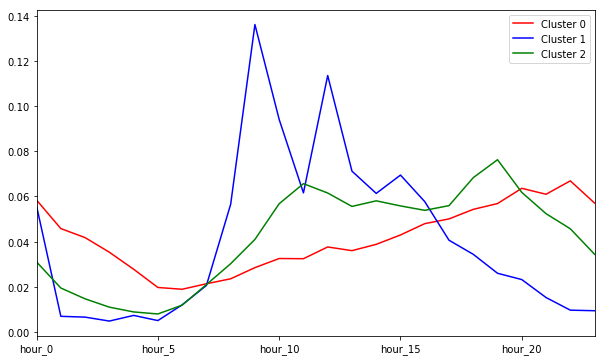

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 6))
hour_cluster0.plot(label='Cluster 0',c='r')
hour_cluster1.plot(label='Cluster 1',c='b')
hour_cluster2.plot(label='Cluster 2',c='g')
plt.legend(loc = 'best', fontsize = 10)

#### b) Describe the three different hour-of-day trends represented by these three clusters (5 pts).

In cluster0, the mean crime values gradually increase throughout the day before peaking at 10PM, then decreasing until morning. 

The mean crime values in cluster1 are significantly higher than the other clusters and rise exponentially between 5AM and 9AM. Cluster1 also experiences a peak around Noon. Given that most crimes in this cluster are taking place during commuting and lunch times, I'll make an educated guess that they are most likely robberies. 

Cluster2 mean crime values increase beginning at 5AM and peaking once around 11AM and again at 7PM.

#### c) Do you notice any consistent trends about which crime types are assigned to which cluster?  Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (5 pts)  


In [17]:
data3['cluster'] = hour_temp_df3['cluster']
list(data3['crime_type'].groupby(data3['cluster']))

[(0, 0                                         ARSON: BY FIRE
  1                    ASSAULT: AGG PO HANDS NO/MIN INJURY
  2                           ASSAULT: AGGRAVATED: HANDGUN
  4                     ASSAULT: AGGRAVATED: OTHER FIREARM
  5                ASSAULT: AGGRAVATED:KNIFE/CUTTING INSTR
  8                    BATTERY: AGG PO HANDS NO/MIN INJURY
  10          BATTERY: AGG: HANDS/FIST/FEET SERIOUS INJURY
  11     BATTERY: AGGRAVATED DOMESTIC BATTERY: HANDS/FI...
  12     BATTERY: AGGRAVATED DOMESTIC BATTERY: KNIFE/CU...
  13     BATTERY: AGGRAVATED DOMESTIC BATTERY: OTHER DA...
  15                          BATTERY: AGGRAVATED: HANDGUN
  16                BATTERY: AGGRAVATED: OTHER DANG WEAPON
  17               BATTERY: AGGRAVATED:KNIFE/CUTTING INSTR
  18                      BATTERY: DOMESTIC BATTERY SIMPLE
  20                                       BATTERY: SIMPLE
  21                      BURGLARY: ATTEMPT FORCIBLE ENTRY
  23                               BURGLARY: HOME INV

Cluster0 consists of mostly violent assaults and robberies.

Cluster1 consists of deceptive crimes such as fraud and identity theft.

Cluster2 has more narcotics and non-violent crimes. 

#### d) Do the three clusters have different day-of-week trends?  Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences.  (5 pts)

In [18]:
# Segmenting data for clustering
day_temp_df3 = data3.iloc[:,2:9]

# Clustering data
n = 3
km = KMeans(n_clusters = n, random_state = 123)
day_temp_df3['cluster'] = km.fit_predict(day_temp_df3)

In [19]:
# Mean values of each cluster
day_cluster0 = day_temp_df3[day_temp_df3['cluster']==0].mean().iloc[0:-1]
day_cluster1 = day_temp_df3[day_temp_df3['cluster']==1].mean().iloc[0:-1]
day_cluster2 = day_temp_df3[day_temp_df3['cluster']==2].mean().iloc[0:-1]

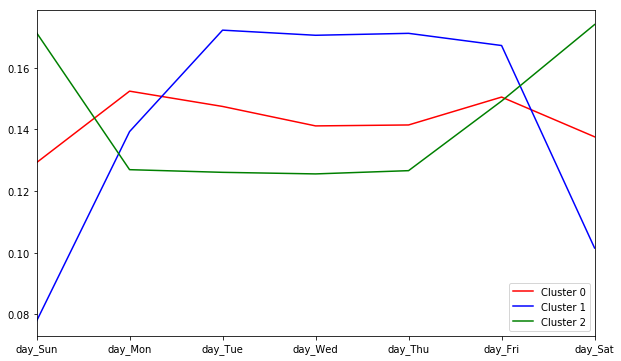

In [20]:
fig = plt.figure(figsize=(10, 6))
day_cluster0.plot(label='Cluster 0',c='r')
day_cluster1.plot(label='Cluster 1',c='b')
day_cluster2.plot(label='Cluster 2',c='g')
plt.legend(loc = 'best', fontsize = 10)

In cluster0, crimes are pretty stable during the week, but decrease slightly during the weekend. 

Crimes in cluster1 have the highest mean values and commonly take place from Tuesday to Friday. The is a steep decline over the weekend.

Cluster2 mean crime values peak over the weekend (Friday to Sunday) and are relatively stable from Monday to Thursday. 

All clusters have fairly similar mean crime values on Fridays. 

#### e) Do the three clusters affect different types of communities/neighborhoods?  To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster.  You can then use the provided file(data4), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.).  (5 pts)


In [21]:
# Segmenting data for clustering
area_temp_df3 = data3.iloc[:,33:]

# Clustering data
n = 3
km = KMeans(n_clusters = n, random_state = 123)
area_temp_df3['cluster'] = km.fit_predict(area_temp_df3)

In [22]:
# list(area_temp_df3.groupby('cluster'))

#### f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)

In [23]:
data3['cluster'] = hour_temp_df3['cluster']
list(data3['Category'].groupby(data3['cluster']))

[(0, 0      P1P
  1       P2
  2      P1V
  4      P1V
  5      P1V
  8       P2
  10     P1V
  11     P1V
  12     P1V
  13     P1V
  15     P1V
  16     P1V
  17     P1V
  18      P2
  20      P2
  21     P1P
  23     P1P
  25     P1V
  26     P1V
  27      P2
  28      P2
  29      P2
  30      P2
  31      P2
  35      P2
  46      P2
  49     P1V
  51      P2
  52      P2
  53     P1P
  54     P1P
  55     P1P
  61      P2
  64      P2
  68      P2
  73      P2
  84      P2
  92      P2
  95     P1V
  96     P1V
  97     P1V
  98     P1V
  99     P1V
  100    P1V
  101    P1V
  102    P1V
  103    P1V
  104     P2
  105     P2
  107     P2
  115     P2
  116     P2
  117     P2
  Name: Category, dtype: object), (1, 6     P2
  19    P2
  36    P2
  37    P2
  38    P2
  41    P2
  42    P2
  43    P2
  44    P2
  45    P2
  87    P2
  93    P2
  Name: Category, dtype: object), (2, 3      P1V
  7       P2
  9       P2
  14     P1V
  22     P1P
  24     P1P
  32      P2
  33      P2


The clusters tend to correspond well with the FBI's categorizations.

Cluster0 has P1V FBI ratings which is consistent with earlier observations of violent assaults and robberies.

Cluster1 is made up of all P2 less serious crimes of fraudently check cashing, which is appropriate. 

Cluster2 mostly has P2 and P1P crimes, with many of them being failure to register, violation, and theft (property crimes). 

#### g) For part g, you will use the same dataset to compare the clusters produced by several different methods.  But this time you should cluster using only the _day-of-week_ (not hour-of-day) attributes.  Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric.  In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify).  For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings. (20 pts)

In [24]:
# Segmenting data for clustering
day_temp_df3 = data3.iloc[:,2:9]

(i) k-means

In [25]:
# Reference: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

from sklearn.metrics import silhouette_score

# Create range for clusters
range_n_clusters = range(2,11)

# Get silhouette score
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=123)
    cluster_labels = clusterer.fit_predict(day_temp_df3)
    print 'For n_clusters = '+ str(n_clusters) + ', the silhouette score is {}'.format(silhouette_score(day_temp_df3, cluster_labels))

For n_clusters = 2, the silhouette score is 0.235578596716
For n_clusters = 3, the silhouette score is 0.229047811398
For n_clusters = 4, the silhouette score is 0.228499425515
For n_clusters = 5, the silhouette score is 0.237893042351
For n_clusters = 6, the silhouette score is 0.166327914294
For n_clusters = 7, the silhouette score is 0.179376444518
For n_clusters = 8, the silhouette score is 0.160026677854
For n_clusters = 9, the silhouette score is 0.165139630641
For n_clusters = 10, the silhouette score is 0.151723501475


In [26]:
# Clustering data
n = 2
km = KMeans(n_clusters = n, random_state = 123)
day_temp_df3['cluster'] = km.fit_predict(day_temp_df3)

In [27]:
day_temp_df3.cluster.value_counts()

0    62
1    57
Name: cluster, dtype: int64

(ii) Gaussian mixture models

In [28]:
from sklearn.mixture import GaussianMixture

# Get silhouette score
for n_clusters in range_n_clusters:
    clusterer = GaussianMixture(n_components=n_clusters, random_state=123)
    cluster_labels = clusterer.fit(day_temp_df3).predict(day_temp_df3)
    print 'For n_clusters = '+ str(n_clusters) + ', the silhouette score is {}'.format(silhouette_score(day_temp_df3, cluster_labels))

For n_clusters = 2, the silhouette score is 0.917402127325
For n_clusters = 3, the silhouette score is 0.614673182389
For n_clusters = 4, the silhouette score is 0.498859533116
For n_clusters = 5, the silhouette score is 0.51630603288
For n_clusters = 6, the silhouette score is 0.398048638462
For n_clusters = 7, the silhouette score is 0.377008840952
For n_clusters = 8, the silhouette score is 0.399058453582
For n_clusters = 9, the silhouette score is 0.213150980921
For n_clusters = 10, the silhouette score is 0.19523832412


In [29]:
# Clustering data
n = 2
gm = GaussianMixture(n_components = n, random_state = 123)
day_temp_df3['cluster'] = gm.fit(day_temp_df3).predict(day_temp_df3)

In [30]:
day_temp_df3.cluster.value_counts()

0    62
1    57
Name: cluster, dtype: int64

(iii) Bottom-up hierarchical clustering with "single link" distance metric

In [31]:
from scipy.cluster.hierarchy import linkage, single, complete, cophenet, dendrogram
from scipy.spatial.distance import pdist

clusterer = linkage(day_temp_df3, method='single')
cluster_labels = single(clusterer)
c, coph_dists = cophenet(clusterer, pdist(day_temp_df3))
c

0.99918424851117515

In [32]:
cluster_labels[0]

array([ 70.        ,  75.        ,   2.44948977,   2.        ])

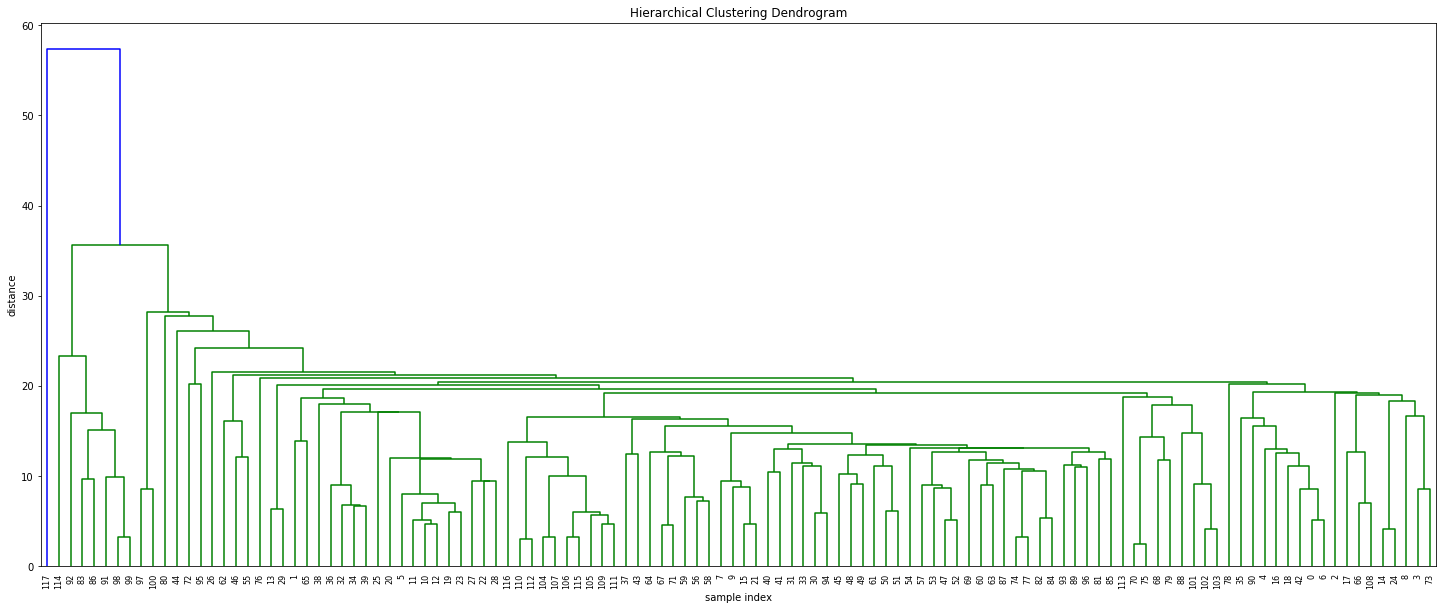

In [33]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    cluster_labels,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

(iv) Bottom-up hierarchical clustering with "complete link" distance metric

In [34]:
clusterer = linkage(day_temp_df3, method='complete')
cluster_labels = complete(clusterer)
c, coph_dists = cophenet(clusterer, pdist(day_temp_df3))
c

0.99836892508461861

In [35]:
cluster_labels[0]

array([ 48.       ,  70.       ,   2.4495376,   2.       ])

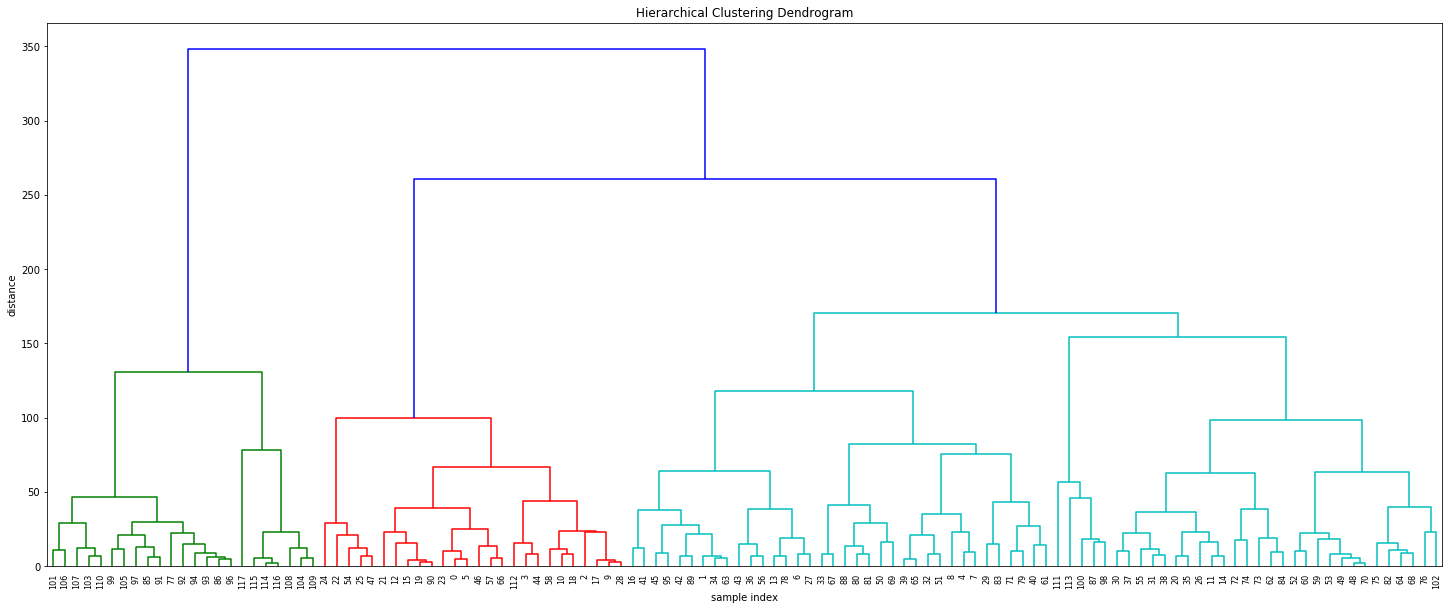

In [36]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    cluster_labels,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()